In [64]:
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier

from Evaluation_Metrics import plot_c_matrix, report_scores, plot_roc_curve

In [49]:
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")
nltk.download('sentiwordnet')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/angelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/angelo/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [50]:
df=pd.read_csv("../Final_Datasets/Dataset_1_train.csv")
df=df.drop(columns="text")
df=df.dropna()
df.polarity=df.polarity-1

In [51]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df['polarity'])

In [52]:
TrainTitleX = list(train_data["title"])[1:]
TrainY = list(train_data["polarity"])[1:]    

TestTitleX = list(test_data["title"])[1:]                  
TestY = list(test_data["polarity"])[1:] 

## Classifier Models

### Naive Bayes

In [53]:
Model = Pipeline([
    ('vect', CountVectorizer(min_df=5)),                #Feature extractor
    ('sel', SelectKBest(mutual_info_classif, k=5000)),  #Feature selector
    ('learner', MultinomialNB())                        #Learning algorithm
])

Model.fit(TrainTitleX, TrainY)
PredictionsModel = Model.predict(TestTitleX)

In [54]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.83      0.79      0.81     19999
           1       0.80      0.84      0.82     19999

    accuracy                           0.81     39998
   macro avg       0.82      0.81      0.81     39998
weighted avg       0.82      0.81      0.81     39998



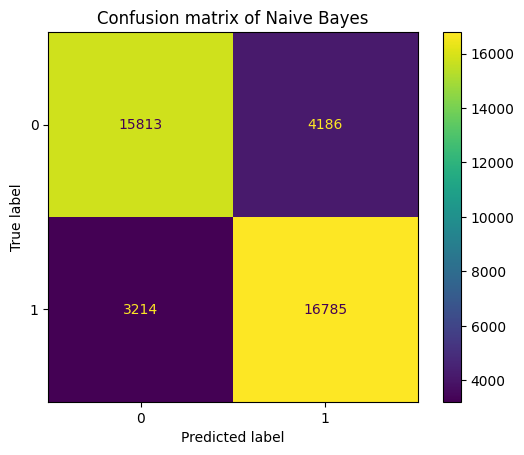

In [55]:
plot_c_matrix(TestY, PredictionsModel, "Naive Bayes")

### Lexicon

In [60]:
class LexiconVader:
  def __init__(self):
    self.__sid_obj = SentimentIntensityAnalyzer()

  def __call__(self, text):
    Result = self.__sid_obj.polarity_scores(text)
    Pos, Neg = Result['pos'], Result['neg']
    return 1 if Pos >= Neg else 0

In [61]:
Model = np.vectorize(LexiconVader())

PredictionsModel = Model(np.array(TestTitleX))

In [62]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.88      0.39      0.54     19999
           1       0.61      0.94      0.74     19999

    accuracy                           0.67     39998
   macro avg       0.74      0.67      0.64     39998
weighted avg       0.74      0.67      0.64     39998



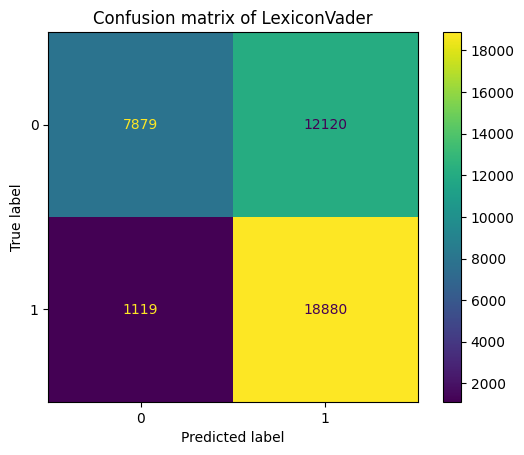

In [63]:
plot_c_matrix(TestY, PredictionsModel, classifier_name="LexiconVader")

### Multi-Layer Perceptron

In [65]:
Model = Pipeline([
    ('vect', CountVectorizer(min_df=5)),                      #Feature extractor
    ('sel', SelectKBest(mutual_info_classif, k=5000)),        #Feature selector
    ('learner', MLPClassifier(random_state=1, max_iter=300))  #Learning algorithm
])

In [66]:
Model.fit(TrainTitleX, TrainY)
PredictionsModel = Model.predict(TestTitleX)

In [67]:
report_scores(TestY, PredictionsModel)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83     19999
           1       0.84      0.81      0.82     19999

    accuracy                           0.83     39998
   macro avg       0.83      0.83      0.83     39998
weighted avg       0.83      0.83      0.83     39998



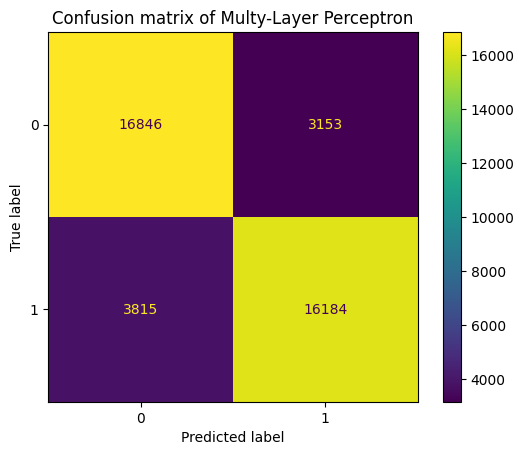

In [69]:
plot_c_matrix(TestY, PredictionsModel, classifier_name="Multy-Layer Perceptron")